# Decoding of neuronal activity with MLP on real data

In this Jupyterbook, we will see a way to decode the neuronal activity.
We will use real data from single neurons recording from the Primary somatosensory cortex during tactile stimulations (stimulation of finger tip 2, 3, 4 or 5)

To Do before the next session, answer the following questions

- what is decoding ? 
- why using an artificial neural network to decode the information contained in single unit data ? 
- why should we use a multi-layer network and not a simple perceptron ? 




In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import random
import warnings
import sys


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('dark_background')

# here DEFINE THE PATH TO YOUR DATA
# Write Here the path to your project root folder
pathroot = 'D:/DATA/Projets/EMN_MLP_NC/'
pathdata = pathroot + '/data' # path to the data folder (i create a folder named "data" in the project root folder)

# open the data
Neuronpop=np.load(pathdata + f'/Neuronpop_0.npz', allow_pickle=True)

np.shape(Neuronpop)

(94,)

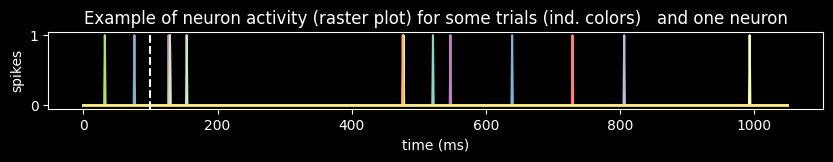

In [6]:
n0=Neuronpop['arr_0']
n0[0,:]
fig, ax= plt.subplots(figsize=(10,1))
plt.plot(n0[0:30,1:].T)
plt.title('Example of neuron activity (raster plot) for some trials (ind. colors)   and one neuron')
plt.xlabel('time (ms)')
plt.ylabel('spikes')
plt.axvline(x=100, color='w', linestyle='--', label='stimulus onset')
plt.show()

The variable Neuronpop contains the data from 94 neurons
Neuronpop['arr_0'] contains the data from the first neuron
Neuronpop['arr_1'] ... from the second....

each rows gives you the activity of the cell for a given trial ( one stimulation trial) over time.
each column, one millisecond 

Column 101 (time=100 ms) corresponds to stimulus onset
Column 0 gives you the information about which finger have been stimulated for the trial.

Neuronpop['arr_0']
for the first trial of the first neuron you have : 

array([2, 0, 0, ..., 0, 0, 0], shape=(1052,), dtype=object)

the 2 in the first col. tells that for the trial the finger 2 was stimulated.
The 0 (or 1) indicated for each ms before and after the stimulation, the non-occurence or occurence of a spike. 

THe following section gives you the raster plots and PSTH (sorted per condition) of some neurons (the 5 first from Neuronpop)

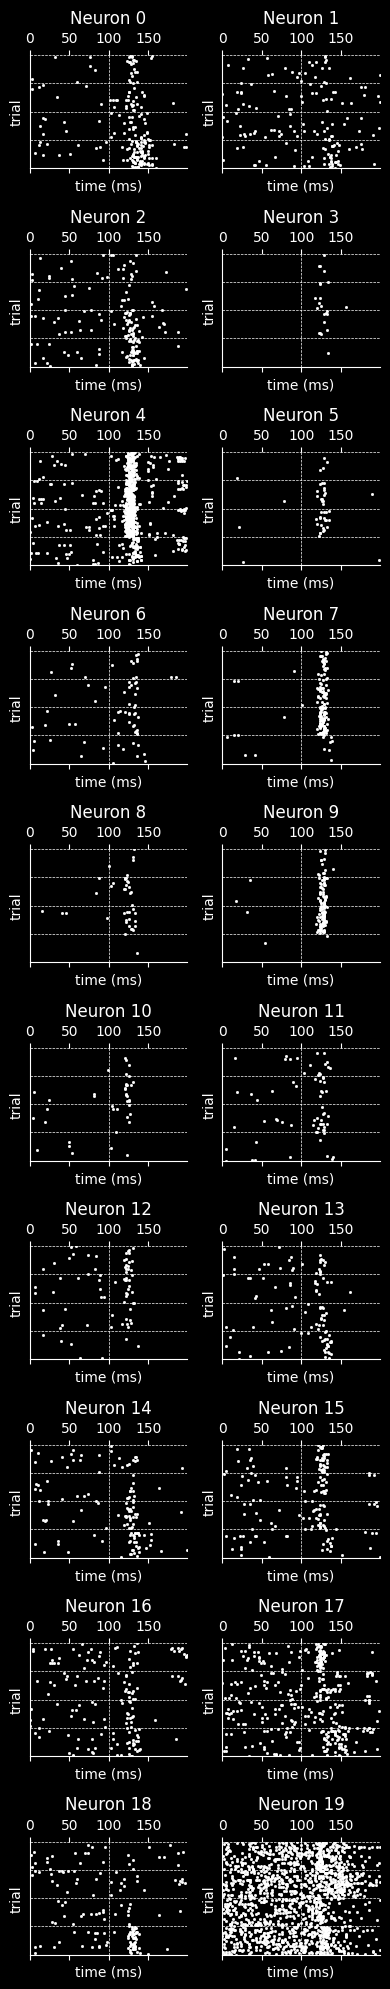

In [7]:
ncells=20
fig, ax = plt.subplots((ncells//2),2,figsize=(4,1*ncells))
ax=ax.flatten()
for neuron in range(ncells):

    sua=Neuronpop[f'arr_{neuron}']
    stim=sua[:,0]
    sua=sua[:,1:]
    ax[neuron].spy(sua[:,0:200], markersize=1,aspect='auto')
    for cond in range(2,6):
        ax[neuron].axhline(np.min(np.where(stim==cond)[0]), color='w', ls='--', lw=0.5)
    ax[neuron].set_title('Neuron '+str(neuron))
    ax[neuron].set_xlabel('time (ms)')
    ax[neuron].set_ylabel('trial')
    ax[neuron].axvline(x=100, color='w', ls='--', lw=0.5)
    ax[neuron].spines['top'].set_visible(False)
    ax[neuron].spines['right'].set_visible(False)
    ax[neuron].set_yticks([])
    # for cond in range(2,5):
    #     ax[neuron,1].plot(np.mean(sua[stim==cond,:], axis=0) )
    # ax[neuron,1].set_title('PSTH')
    # ax[neuron,1].set_xlabel('time (ms)')
    # ax[neuron,1].set_ylabel('firing rate (spikes/s)')
    # ax[neuron,1].spines['top'].set_visible(False)
    # ax[neuron,1].spines['right'].set_visible(False)
    # ax[neuron,1].set_xlim([100, 150])
plt.tight_layout()
plt.show()


Preparation of the data for classification

In [ ]:
ncells=len(Neuronpop.files)
mintrial=100
onset=100
offset=150
Unitpop=[]
for neuron in range(ncells):

    sua=Neuronpop[f'arr_{neuron}']
    
    Unit2r=random.sample(sua[sua[:,0]==2].tolist(), mintrial)
    Unit3r=random.sample(sua[sua[:,0]==3].tolist(), mintrial)
    Unit4r=random.sample(sua[sua[:,0]==4].tolist(), mintrial)
    Unit5r=random.sample(sua[sua[:,0]==5].tolist(), mintrial)

    Unit=np.concatenate((Unit2r,Unit3r,Unit4r,Unit5r), axis=0)

    UnitTime=np.sum(Unit[:,onset:offset], axis=1)
    UnitTime[UnitTime>0]=1
    #UnitTime[np.isnan(UnitTime)] = 0 # pas sur de celle la mais sinon ça ne marche pas je pige pas pourquoi il y a des NaN
    
    Unitpop.append(UnitTime)

StimTarget=Unit[:,0]
StimTarget=np.reshape(StimTarget, (400,1))
Unitpop=np.transpose(Unitpop)

Unitpop_df=pd.DataFrame(Unitpop)
Unitpop_df



,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Classification with a simple KNN

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Cross-validation for KNN to evaluate model performance more robustly


# Perform cross-validation with different k values
cv_scores = []
k_range = range(1, 31)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='jaccard')
    scores = cross_val_score(knn, Unitpop, StimTarget.ravel(), cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the best k value
best_k_cv = k_range[np.argmax(cv_scores)]
best_score_cv = max(cv_scores)

print(f'Best k from CV: {best_k_cv}')
print(f'Best CV accuracy: {best_score_cv*100:.2f}%')

X_train, X_test, y_train, y_test = train_test_split(Unitpop, StimTarget, test_size=0.2)

model = KNeighborsClassifier(n_neighbors=best_k_cv, metric='jaccard')
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
print(f'KNN Accuracy: {accuracy*100:.2f}%')

Best k from CV: 23
Best CV accuracy: 57.25%
KNN Accuracy: 50.00%


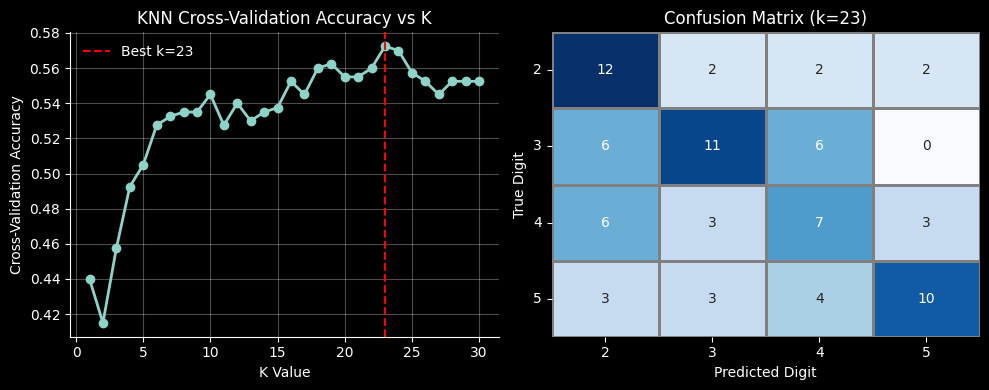

In [49]:
# Plot confusion matrix and training history from cross-validation results

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot CV scores vs k
ax[0].plot(k_range, cv_scores, marker='o', linestyle='-', linewidth=2)
ax[0].set_xlabel('K Value')
ax[0].set_ylabel('Cross-Validation Accuracy')
ax[0].set_title('KNN Cross-Validation Accuracy vs K')
ax[0].grid(True, alpha=0.3)
ax[0].axvline(x=best_k_cv, color='r', linestyle='--', label=f'Best k={best_k_cv}')
ax[0].legend(frameon=False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Plot confusion matrix for best model
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[1], linewidths=1, linecolor='gray')
ax[1].set_xticklabels(['2','3','4','5'])
ax[1].set_yticklabels(['2','3','4','5'], rotation=0)
ax[1].set_xlabel('Predicted Digit')
ax[1].set_ylabel('True Digit')
ax[1].set_title(f'Confusion Matrix (k={best_k_cv})')

plt.tight_layout()
plt.show()

Classification with a perceptron for N neurons and 2 classes


Accuracy: 0.78


Text(0.5, 1.0, 'Perceptron Confusion Matrix')

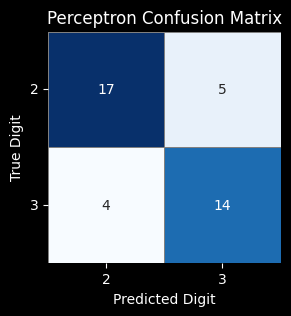

In [ ]:
## perceptron for N neurons and 2 classes
### using sklearn Perceptron

from sklearn.linear_model import Perceptron

Nneurons=94 # choose number of neurons to use

X=Unitpop[0:200,0:Nneurons] # only 2 classes: 2 and 3

y=StimTarget[0:200]-2 # to have labels 0,1,2,3 instead of 2,3,4,5  only 0 and 1 here

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create and train the Perceptron model
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

# Make predictions on the test set
y_pred = perceptron.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,linewidths=0.5, linecolor='gray')
ax.set_xticklabels(['2','3'])
ax.set_yticklabels(['2','3'], rotation=0)
ax.set_xlabel('Predicted Digit')
ax.set_ylabel('True Digit')
ax.set_title('Perceptron Confusion Matrix')


Perceptron for N neurons and 4 classes


In [74]:
## MLP for N neurons and 4 classes


Nneurons=np.shape(Unitpop)[1]

X=Unitpop[:,0:Nneurons]
y=StimTarget-2 # to have labels 0,1,2,3 instead of 2,3,4,5

AccScore_MLP=[]
CM_NN=np.zeros((4,4))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=0)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# THE MODEL 
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))

model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=0)

history = model.history.history
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
AccScore_MLP.append(accuracy_score(y_test, y_pred))

loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
accuracy = accuracy * 100
print(f'Test accuracy: {accuracy:.2f}%')
print(f'loss: {loss:.4f}')

cm=confusion_matrix(y_test, y_pred)
model.summary()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6625 - loss: 0.9397  
Test accuracy: 66.25%
loss: 0.9397


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 94)             │         8,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 16)             │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,556 (123.27 KB)

 Trainable params: 10,518 (41.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,038 (82.18 KB)

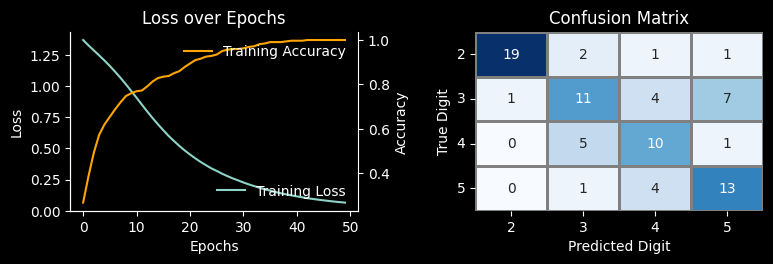

In [76]:

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(history['loss'], label='Training Loss')
ax[0].set_title('Loss over Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='lower right',frameon=False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax2 = ax[0].twinx()
ax2.plot(history['accuracy'], label='Training Accuracy', color='orange')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right',frameon=False)
ax2.spines['top'].set_visible(False)
sns.heatmap(cm, cmap='Blues', ax=ax[1], annot=True, fmt='d',cbar=False,linewidths=1, linecolor='gray')
ax[1].set_xticklabels(['2','3','4','5'])
ax[1].set_yticklabels(['2','3','4','5'], rotation=0)
ax[1].set_xlabel('Predicted Digit')
ax[1].set_ylabel('True Digit')
ax[1].set_title('Confusion Matrix')
plt.tight_layout(pad=2.0)


In [3]:
s=[0,1,2,3,4]
w=[50,60,80,100,60]
h=[178,198,218,238,198]
d=[0,1,0,1,1]
data=pd.DataFrame({'subject':s, 'weight':w, 'height':h, 'disease':d})

data

,subject,weight,height,disease
0,0,50,178,0
1,1,60,198,1
2,2,80,218,0
3,3,100,238,1
4,4,60,198,1
